In [ ]:
# @title Imports
import json
import heapq
import math
import time
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from math import cos, radians, sqrt
import matplotlib.patches as patches


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def plot_cities(cities, s_city, f_city):
    plt.figure(figsize=(10, 8))
    for name, lat, lon, _ in cities:
        if name == s_city:
            plt.plot(lon, lat, 'ro', markersize=8, label='Cidade Inicial')
        elif name == f_city:
            plt.plot(lon, lat, 'go', markersize=8, label='Cidade Final')
        else:
            plt.plot(lon, lat, 'bo', markersize=4)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Mapa das Cidades')
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
def plot_graph(cities, graph, s_city, f_city):
    G = nx.Graph()
    pos = {}

    lons = []
    lats = []

    for name, lat, lon, _ in cities:
        G.add_node(name)
        pos[name] = (lon, lat)
        lons.append(lon)
        lats.append(lat)

    for city, neighbors in graph.items():
        for neighbor, dist in neighbors:
            G.add_edge(city, neighbor, weight=dist)

    node_colors = []
    for node in G.nodes:
        if node == s_city:
            node_colors.append('red')
        elif node == f_city:
            node_colors.append('green')
        else:
            node_colors.append('skyblue')

    fig, ax = plt.subplots(figsize=(12, 10))

    min_lon, max_lon = min(lons)-1, max(lons)+1
    min_lat, max_lat = min(lats)-1, max(lats)+1

    ax.set_xlim(min_lon, max_lon)
    ax.set_ylim(min_lat, max_lat)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Grafo das Cidades')

    step = 1
    for x in np.arange(min_lon, max_lon, step):
        for y in np.arange(min_lat, max_lat, step):
            rect = patches.Rectangle(
                (x, y), step, step,
                linewidth=0.5,
                edgecolor='gray',
                facecolor='lightgray',
                alpha=0.15  # Transparência
            )
            ax.add_patch(rect)

    nx.draw(G, pos, with_labels=False, node_size=30, node_color=node_colors, edge_color='gray', ax=ax)

    plt.show()

In [ ]:
def euclidean_distance(coord_city1, coord_city2):
    lat1, lon1 = coord_city1
    lat2, lon2 = coord_city2

    avg_lat = radians((lat1 + lat2) / 2.0)
    dx = (lon2 - lon1) * 111 * cos(avg_lat)
    dy = (lat2 - lat1) * 111
    return sqrt(dx*dx + dy*dy)

In [ ]:
# @title A*
def a_star(graph, h_func, pop_fc, start, goal):
    open_set = []
    heapq.heappush(open_set, (h_func[start], 0, pop_fc[start], start, [start]))
    visited = set()

    iterations = 0

    while open_set:
        f, g, pop, current, path = heapq.heappop(open_set)

        if current == goal:
            return path, g, iterations

        if current in visited:
            continue
        visited.add(current)

        for neighbor, cost in graph.get(current, []):
            iterations += 1

            if neighbor not in visited:
                new_g = g + cost
                new_f = new_g + h_func.get(neighbor, float('inf'))
                heapq.heappush(open_set, (new_f, new_g, pop_fc[neighbor], neighbor, path + [neighbor]))

    return None, float('inf'), iterations

In [ ]:
# @title Bellman-Ford
def bellman_ford(graph, pop_fc, start, goal):
    dist = {node: float('inf') for node in graph}
    pred = {node: None for node in graph}
    dist[start] = 0

    iterations = 0
    nodes = list(graph.keys())

    for _ in range(len(nodes) - 1):
        updated = False
        for u in nodes:
            for v, cost in graph[u]:
                iterations += 1
                if dist[u] + cost < dist[v]:
                    dist[v] = dist[u] + cost
                    pred[v] = u
                    updated = True
                elif abs(dist[u] + cost - dist[v]) < 1e-6:  # empate
                    if pred[v] is None or pop_fc[u] < pop_fc[pred[v]]:
                        pred[v] = u
                        updated = True
        if not updated:
            break

    def reconstruct_path(pred, start, goal):
        path = []
        current = goal
        while current is not None:
            path.append(current)
            current = pred[current]
        path.reverse()
        return path if path[0] == start else None

    path = reconstruct_path(pred, start, goal)
    return path, dist[goal], iterations

In [ ]:
def run_algorithms(radius, s_city, f_city):
    json_path = '/content/drive/MyDrive/Mestrado/IA/cities.json'

    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    graph = {}
    cities = []
    h_func = {}
    pop_fc = {}
    h_func[f_city] = 0.0

    for item in data:
        city = item['city']
        state = item['state']
        latitude = float(item['latitude'])
        longitude = float(item['longitude'])
        population = int(item['population'].replace(',', ''))
        name = city + ', ' + state
        cities.append((name, latitude, longitude, population))

    for i in range(len(cities)):
        name1, lat1, long1, pop1 = cities[i]
        graph[name1] = []
        pop_fc[name1] = pop1

        for j in range(len(cities)):
            if i == j:
                continue
            name2, lat2, long2, pop2 = cities[j]
            dist = euclidean_distance((lat1, long1), (lat2, long2))
            if dist <= radius:
                graph[name1].append((name2, dist))
            if name2 == f_city:
                h_func[name1] = dist

    start_time = time.time()
    path_a, cost_a, iterations_a = a_star(graph, h_func, pop_fc, s_city, f_city)
    end_time = time.time()
    print("\nAlgoritmo A*")
    if path_a:
        print("Caminho encontrado:")
        for c in path_a:
            print(c)
        print("Custo total:", cost_a)
    else:
        print("Nenhum caminho encontrado.")
    print("Iterações:", iterations_a)
    print("Tempo (s):", end_time - start_time)

    start_time = time.time()
    path_bf, cost_bf, iterations_bf = bellman_ford(graph, pop_fc, s_city, f_city)
    end_time = time.time()
    print("\nAlgoritmo Bellman-Ford")
    if path_bf:
        print("Caminho encontrado:")
        for c in path_bf:
            print(c)
        print("Custo total:", cost_bf)
    else:
        print("Nenhum caminho encontrado.")
    print("Iterações:", iterations_bf)
    print("Tempo (s):", end_time - start_time)

    return graph, cities

In [ ]:
r = 200
s_city = "Philadelphia, Pennsylvania"
f_city = "Baltimore, Maryland"
graph, cities = run_algorithms(r, s_city, f_city)


Algoritmo A*
Caminho encontrado:
Philadelphia, Pennsylvania
Baltimore, Maryland
Custo total: 143.9048081996412
Iterações: 48
Tempo (s): 0.000118255615234375

Algoritmo Bellman-Ford
Caminho encontrado:
Philadelphia, Pennsylvania
Baltimore, Maryland
Custo total: 143.9048081996412
Iterações: 473704
Tempo (s): 0.1331019401550293


In [ ]:
r = 100
s_city = "Los Angeles, California"
f_city = "Riverside, California"
graph, cities = run_algorithms(r, s_city, f_city)


Algoritmo A*
Caminho encontrado:
Los Angeles, California
Riverside, California
Custo total: 78.75831215192156
Iterações: 96
Tempo (s): 0.00023412704467773438

Algoritmo Bellman-Ford
Caminho encontrado:
Los Angeles, California
Riverside, California
Custo total: 78.75831215192156
Iterações: 75294
Tempo (s): 0.0453183650970459


In [ ]:
r = 70
s_city = "Los Angeles, California"
f_city = "Riverside, California"
graph, cities = run_algorithms(r, s_city, f_city)


Algoritmo A*
Caminho encontrado:
Los Angeles, California
La Puente, California
Riverside, California
Custo total: 78.75882635338102
Iterações: 161
Tempo (s): 0.0002694129943847656

Algoritmo Bellman-Ford
Caminho encontrado:
Los Angeles, California
La Puente, California
Riverside, California
Custo total: 78.75882635338102
Iterações: 75168
Tempo (s): 0.02126932144165039


In [ ]:
r = 1000
s_city = "Honolulu, Hawaii"
f_city = "New York, New York"
graph, cities = run_algorithms(r, s_city, f_city)


Algoritmo A*
Nenhum caminho encontrado.
Iterações: 0
Tempo (s): 2.0503997802734375e-05

Algoritmo Bellman-Ford
Nenhum caminho encontrado.
Iterações: 251952
Tempo (s): 0.05449032783508301


In [ ]:
r = 300
s_city="Suffolk, Virginia"
f_city="El Paso, Texas"
graph, cities = run_algorithms(r, s_city, f_city)


Algoritmo A*
Caminho encontrado:
Suffolk, Virginia
Danville, Virginia
Johnson City, Tennessee
Knoxville, Tennessee
Franklin, Tennessee
Collierville, Tennessee
Pine Bluff, Arkansas
Texarkana, Texas
Carrollton, Texas
Coppell, Texas
Abilene, Texas
Lubbock, Texas
Roswell, New Mexico
El Paso, Texas
Custo total: 2915.1584395203813
Iterações: 6375
Tempo (s): 0.0056934356689453125

Algoritmo Bellman-Ford
Caminho encontrado:
Suffolk, Virginia
Danville, Virginia
Johnson City, Tennessee
Knoxville, Tennessee
Franklin, Tennessee
Collierville, Tennessee
Pine Bluff, Arkansas
Texarkana, Texas
Carrollton, Texas
Coppell, Texas
Abilene, Texas
Lubbock, Texas
Roswell, New Mexico
El Paso, Texas
Custo total: 2915.1584395203813
Iterações: 1099332
Tempo (s): 0.2702152729034424


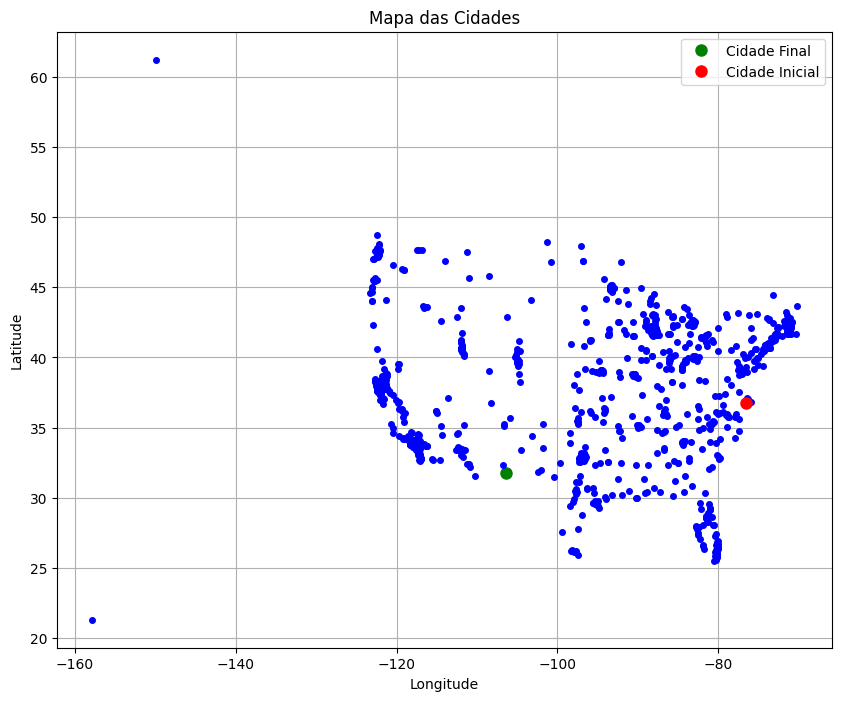

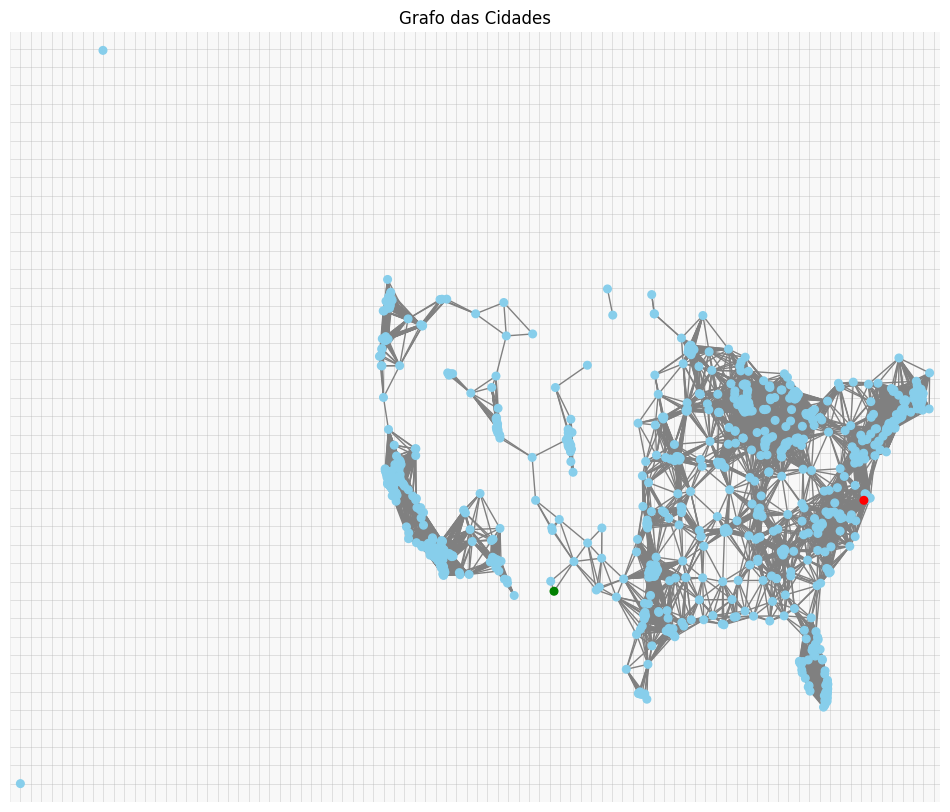

In [ ]:
plot_cities(cities, s_city, f_city)
plot_graph(cities, graph, s_city, f_city)

In [ ]:
json_path = '/content/drive/MyDrive/Mestrado/IA/cities.json'

with open(json_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

cities = []
honolulu_coords = None

for item in data:
    city = item['city']
    state = item['state']
    lat = float(item['latitude'])
    lon = float(item['longitude'])

    name = f"{city}, {state}"
    cities.append((name, lat, lon))

    if name.lower() == "honolulu, hawaii":
        honolulu_coords = (lat, lon)

if not honolulu_coords:
    raise ValueError("Honolulu, Hawaii não foi encontrado no arquivo JSON.")

min_dist = float('inf')
closest_city = None

for name, lat, lon in cities:
    if name.lower() == "honolulu, hawaii":
        continue
    dist = euclidean_distance(honolulu_coords, (lat, lon))
    if dist < min_dist:
        min_dist = dist
        closest_city = name

print(f"A cidade mais próxima de Honolulu, Hawaii é: {closest_city} (Distância: {min_dist:.4f})")

A cidade mais próxima de Honolulu, Hawaii é: Pacifica, California (Distância: 3868.1797)
